In [1]:

seed = 43
import random
random.seed(seed)

import torch
torch.manual_seed(seed)

import numpy as np
np.random.seed(seed)

import matplotlib.pyplot as plt
from datasets.baseprim.marked_integer_dataset import MixedSprites3Dataset

from datasets.baseprim.shape3 import Shapes3Dataset

dataset_size =2048
test_size = 256

percent = 0.5
train_dataset = MixedSprites3Dataset(dataset_size=dataset_size// 1, p = percent)  # create a dataset with 1024 samples
test_dataset = MixedSprites3Dataset(dataset_size=test_size, p = percent)  # create a dataset with 128 samples for testing

#train_dataset = Shapes3Dataset(dataset_size = 1024)
#test_dataset = Shapes3Dataset(dataset_size = 128)

corpus = [data[1]["query"] for data in train_dataset]

#from data.collect_corpus import write_vocab, load_corpus, build_vocab
#vocab = build_vocab([] + corpus)
##write_vocab(vocab)


In [2]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/prototype")
### load the meta learner from the pretrained-checkpoint
pass


14 20:07:31 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
14 20:07:31 WRN `SearchExecutor` The input domain is empty, creating an empty domain
14 20:07:31 Function one automatically registered.
14 20:07:31 Function two automatically registered.
14 20:07:31 Function three automatically registered.
14 20:07:31 Function plus automatically registered.
14 20:07:31 Function minus automatically registered.
14 20:07:31 Function mul automatically registered.
14 20:07:31 Function avg automatically registered.
14 20:07:31 Function smaller automatically registered.
14 20:07:31 Function bigger automatically registered.
14 20:07:31 Function N automatically registered.
14 20:07:31 Function Z automatically registered.
14 20:07:31 Function max automatically registered.
14 20:07:31 Function subset automatically registered.
14 20:07:31 Function exists automatically registered.
14 20:07:31 Function forall automatically registered.
14 20:07:31 Function iota automatically registere

# Base Knowledge Learning


14 20:07:31 Filter dataset None: #before=2048, #after=1005.
14 20:07:31 Filter dataset None: #before=256, #after=123.


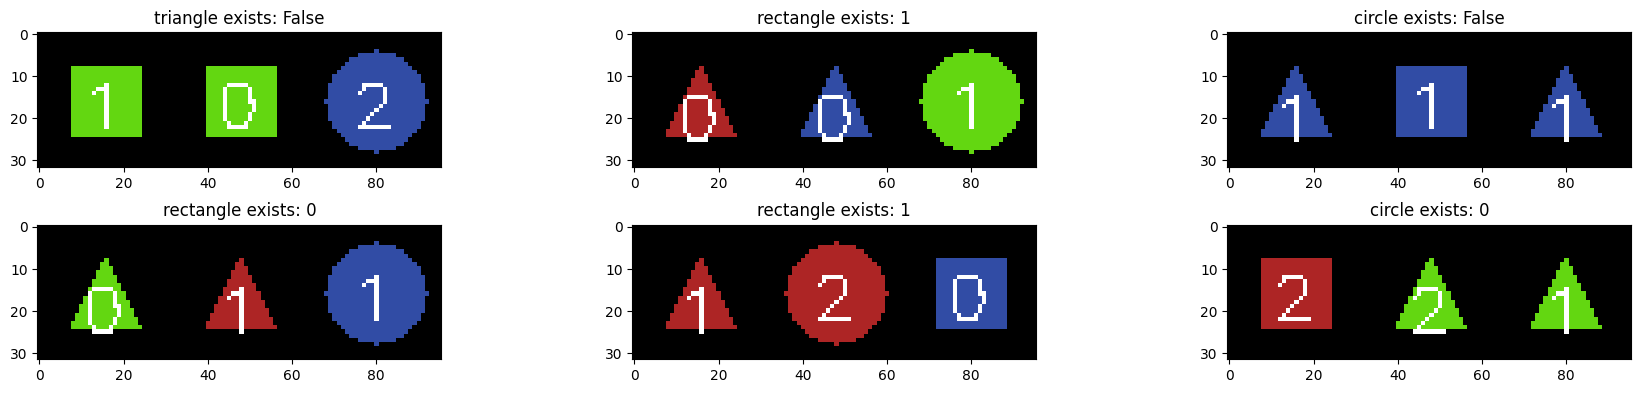

In [3]:
from core.learn import AutoLearnSchedule
from helchriss.logger import set_logger_output_file

valid_types = ["boolean"]
train_logic_dataset = train_dataset.filter(lambda x : x["question_type"] in valid_types)
test_logic_dataset = test_dataset.filter(lambda x : x["question_type"] in valid_types)

# Now let's visualize a few samples from the dataset:
"arithmetic"

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    #print(train_logic_dataset[i]['image'].permute(1, 2, 0).numpy()[...,::-1].shape)
    plt.imshow(train_logic_dataset[i]['image'].permute(1, 2, 0).numpy())
    plt.title(train_logic_dataset[i]['query'] + ': ' + str(train_dataset[i]['answer']))
    #stprint(train_dataset[i])
plt.tight_layout()
plt.show()



In [4]:

learner.cheat = 1
#learner.executor.supressed = 1
set_logger_output_file(f"outputs/logs/expr_{dataset_size // 1}.txt")
schedule = AutoLearnSchedule(train_logic_dataset, test_logic_dataset)

schedule.procedual_train(learner, lr = 1e-3)
learner.save_ckpt("outputs/checkpoints/logic")

14 20:07:31 start to learn the words ['rectangle', 'green', 'red', 'triangle', 'blue', 'exists', 'circle', 'sprite'], add corpus size 1005
14 20:07:31 unification structure check, eval run
Training epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]/Users/sunyiqi/Documents/GitHub/MetaLearner/core/metaphors/executor.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_info = (node_id, son_id, {"weight":float(torch.exp(torch.tensor(-subloss)) )})
/Users/sunyiqi/Documents/GitHub/MetaLearner/domains/logic/fol_domain.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_info = (node_id, son_id, {"weight":float(torch.exp(torch.tensor(-subloss)) )})
Training epochs: 100%|██████████| 1/1 

0

14 20:09:07 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
14 20:09:07 WRN `SearchExecutor` The input domain is empty, creating an empty domain
14 20:09:07 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
14 20:09:07 WRN `SearchExecutor` The input domain is empty, creating an empty domain


red [0 1 0]
red count is : 1
green [1 0 0]
green count is : 1
blue [0 0 1]
blue count is : 1
circle [0 0 1]
circle count is : 1
rectangle [0 0 0]
rectangle count is : 0
triangle [1 1 0]
triangle count is : 2


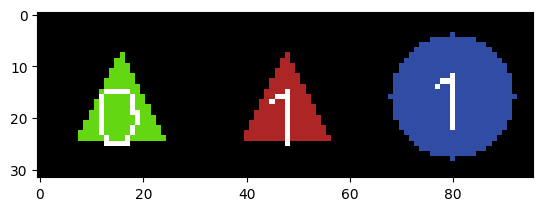

In [5]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/logic")

i = 3
img = train_logic_dataset[i]['image']
grounding = {"image": img}
plt.imshow(img.permute(1, 2, 0).numpy())

tags = ["red","green", "blue", "circle", "rectangle", "triangle"]

for tag in tags:
    program = f"filter:Logic(scene:Objects(), {tag}:Objects )"
    measure, _ = learner.executor.additive_evaluation(program, grounding)
    print(tag,(measure.value[:,0].sigmoid() + 0.5).int().detach().numpy())

    program = f"count:Logic( filter:Logic(scene:Objects(), {tag}:Objects ) )"
    measure, _ = learner.executor.additive_evaluation(program, grounding)
    print(f"{tag} count is : {int(measure.value +0.5)}")
    

In [6]:
#learner.save_ckpt("outputs/checkpoints/logic") #avg_loss=3.0656, avg_acc=0.5201


# Continual Learning Concepts
MetaLearner can continually learning new concepts using only language description of the new word and the related domain entries.

14 20:09:08 Filter dataset None: #before=2048, #after=2048.
14 20:09:08 Filter dataset None: #before=256, #after=256.


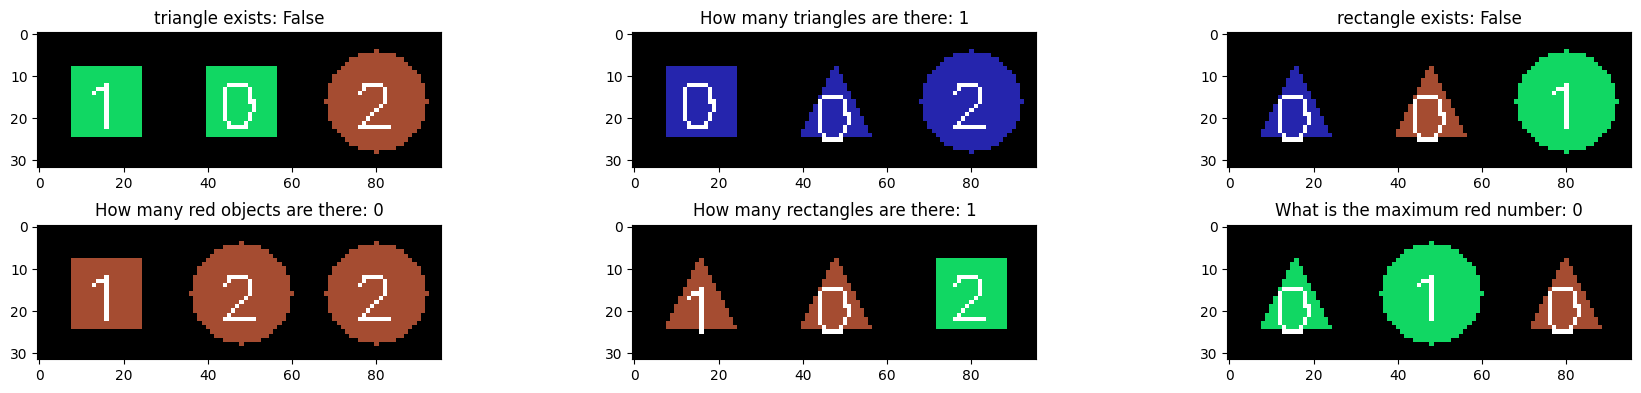

In [7]:
valid_types = ["boolean", "arithmetic"]
train_arith_dataset = train_dataset.filter(lambda x : x["question_type"] in valid_types)
test_arith_dataset = test_dataset.filter(lambda x : x["question_type"] in valid_types)

# Now let's visualize a few samples from the dataset:
"arithmetic"

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_arith_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1])
    plt.title(train_arith_dataset[i]['query'] + ': ' + str(train_dataset[i]['answer']))
    #stprint(train_dataset[i])
plt.tight_layout()
plt.show()


In [8]:

learner.executor.supressed = 1
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/logic")
import torch.nn as nn
def freeze(model : nn.Module):
    for param in model.parameters():
        param.requires_grad = False

learner
learner.cheat = 1

set_logger_output_file(f"outputs/logs/expr_{dataset_size // 1}.txt")
schedule = AutoLearnSchedule(train_arith_dataset, test_arith_dataset)
schedule.procedual_train(learner, lr = 2e-4)
learner.save_ckpt("outputs/checkpoints/max1")

14 20:09:08 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
14 20:09:08 WRN `SearchExecutor` The input domain is empty, creating an empty domain
14 20:09:08 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
14 20:09:08 WRN `SearchExecutor` The input domain is empty, creating an empty domain
14 20:09:09 start to learn the words ['circles', 'there', 'exists', 'circle', 'rectangle', 'blue', 'number', 'What', 'are', 'rectangles', 'maximum', 'triangles', 'sprite', 'many', 'is', 'objects', 'green', 'red', 'triangle', 'How', 'the'], add corpus size 2048
14 20:09:09 unification structure check, eval run
Training epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]14 20:09:09 execution not found for max:Integer([List[Tuple[bool, Embedding[object, 64]]]])
14 20:09:09 update chain : max:Integer -> [List[Tuple[bool, Embedding[object, 64]]]]
Training epochs: 100%|██████████| 1/1 [00:11<00:00, 11.33s/epoch, test_acc=-1.0000]
14 20:09:21 training until conver

0

In [9]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/max1")
pass

14 20:15:02 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
14 20:15:02 WRN `SearchExecutor` The input domain is empty, creating an empty domain
14 20:15:02 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
14 20:15:02 WRN `SearchExecutor` The input domain is empty, creating an empty domain


max:Integer#List[Tuple[bool, Embedding[object, 64]]]->float
outputs/checkpoints/max1/extended/max:Integer#List[Tuple[bool, Embedding[object, 64]]]->float.ckpt


max:Integer(scene:Objects() ) tensor(2.0005, grad_fn=<AddBackward0>)


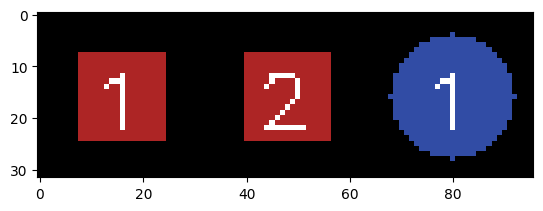

In [15]:

i = 8
img = train_arith_dataset[i]['image']
grounding = {"image": img}
plt.imshow(img.permute(1, 2, 0).numpy())

tags = ["red","green", "blue", "circle", "rectangle", "triangle"]

tag1 = "green"
tag2 = "circle"

program = f"plus:Integer(filter:Logic(scene:Objects(), {tag1}:Objects ), filter:Logic(scene:Objects(), {tag2}:Objects ))"

program = f"max:Integer(scene:Objects() )"
#program = f"count:Logic(filter:Logic(scene:Objects(), {tag1}:Objects ))"

from core.model import value_types, UnificationFailure

try:
    measure, _ = learner.executor.additive_evaluation(program, grounding)
except UnificationFailure as e:
    print("Unify:",e.left_structure, value_types(e.right_structure))
    learner.executor.update_chain(e.right_structure, e.left_structure)

print(program,measure.value)


# Euclid Domain for Path and Container

In [11]:

if __name__ == "__main__":
    from domains.math.euclid_domain import euclid_executor
    from datasets.baseprim.euclid_dataset import generate_constrained_scene

    
    # Generate constrained scene
    scene_img, scene_meta = generate_constrained_scene(euclid_executor)
    
    # Print metadata (DSL program + object specs)
    print(f"\nScene Metadata: {scene_meta['objects']}")
    
    # Save rendered scene
    import PIL.Image as Image
    img_np = (scene_img.permute(1,2,0).cpu().numpy() * 255).astype("uint8")
    Image.fromarray(img_np).save("constrained_scene_example.png")
    print("Constrained scene saved as 'constrained_scene_example.png'")

14 20:15:02 Function start automatically registered.
14 20:15:02 Function end automatically registered.
14 20:15:02 Function on_line automatically registered.
14 20:15:02 Function length automatically registered.
14 20:15:02 Function intersect automatically registered.
14 20:15:02 Function parallel automatically registered.
14 20:15:02 Function perpendicular automatically registered.
14 20:15:02 Function connect_segment automatically registered.
14 20:15:02 Function center automatically registered.
14 20:15:02 Function radius automatically registered.
14 20:15:02 Function on_radius automatically registered.
14 20:15:02 Function inside automatically registered.
14 20:15:02 Function outside automatically registered.
14 20:15:02 Function contain automatically registered.
14 20:15:02 Function intersect_line_circle automatically registered.
14 20:15:02 Function tangent automatically registered.
14 20:15:02 Function contained_line automatically registered.


Generated DSL Program: l1:line(p1,p2)[color(green)];l2:line(p2,p3)[perpendicular(l2, l1),color(blue)];l3:line(p3,p4)[perpendicular(l3, l2),color(red)] ;l4:line(p4,p1)[color(blue)]

Scene Metadata: [{'name': 'l1', 'type': 'line', 'geometry': tensor([192.7963, 117.0326,  33.8857,  38.3903]), 'color_name': 'green', 'color_rgb': tensor([0., 1., 0.])}, {'name': 'l2', 'type': 'line', 'geometry': tensor([ 33.8857,  38.3903,  97.9688, -91.1009]), 'color_name': 'blue', 'color_rgb': tensor([0.6376, 0.0000, 1.0000])}, {'name': 'l3', 'type': 'line', 'geometry': tensor([ 97.9688, -91.1009, 389.3900,  53.1188]), 'color_name': 'red', 'color_rgb': tensor([1.0000, 0.1208, 0.5987])}, {'name': 'l4', 'type': 'line', 'geometry': tensor([389.3900,  53.1188, 192.7963, 117.0326]), 'color_name': 'blue', 'color_rgb': tensor([0.2894, 0.0000, 1.0000])}]
Constrained scene saved as 'constrained_scene_example.png'


In [12]:
from core.metaphors.types import find_transform_path, TransformRule, PatternVar
from helchriss.dsl.dsl_types import FLOAT, ListType, VectorType, EmbeddingType, TypeBase
from typing import Dict

if __name__ == "__main__":

        # source type : List[Vector[float, 3]]",
        initial_type = ListType(element_type=VectorType(elem_type=FLOAT, dim=3),
        )
        # target type：List[Embedding["vec3", 3]]",
        target_type = ListType(element_type=EmbeddingType(space_name="vec3", dim=3),
        )
    
        rule_pattern = ListType(
            element_type=VectorType(elem_type=PatternVar("n"), dim=PatternVar("d"))  # $d匹配任意维度\n",
        )

        def vec_to_embedding(bindings: Dict[str, TypeBase]) -> TypeBase:
            d = bindings["d"] 
            return ListType(
                element_type=EmbeddingType(space_name="vec3", dim=d),
            )
        transform_rule = TransformRule(
            source_pattern=rule_pattern,
            transform_func=vec_to_embedding,
        )

        path = find_transform_path(
            initial_type=initial_type,
            target_type=target_type,
            rules=[transform_rule],
            max_depth=3,
        )
        if path is not None:
            print(f"Found path from {initial_type} to {target_type}"),

            for i, (rule, bindings) in enumerate(path):
                print(f"step{i+1} apply rule on the binding:"),
                for var, typ in bindings.items():
                    print(f"  {var} = {typ}"),
            print()
        else:
            print(f"cannot transform from {initial_type} to {target_type}"),



Found path from List[Vector[float,3]] to List[Embedding[vec3, 3]]
step1 apply rule on the binding:
  n = float
  d = 3



In [13]:
print(isinstance(3, (float, int)))

True
